In [1]:
from qTools import *
import Cahit as ck

import scipy.sparse as sp
import numpy as np

from functools import partial
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import datetime

In [2]:
resonatorDimension = 200
g = 1.79
qfreq = 0
resFreq = 2
irreg = False

In [3]:
qSim = Simulation()
JCSys = qSim.qSys
qSim.delState = True

In [4]:
cav = Cavity(dimension=resonatorDimension, frequency=resFreq)
JCSys.addSubSys(cav)

qub = JCSys.createSubSys(subClass=Qubit)
qub.frequency = qfreq

Cavity requires a dimension
Qubit requires a dimension


In [5]:
digitalRabi = qProtocol(superSys=JCSys)
JCunitary = freeEvolution(ratio=0.5, superSys=JCSys)
bitFlip = xGate(implementation='instant', superSys=qub, fixed=True)
digitalRabi.addStep(JCunitary, bitFlip, JCunitary, JCunitary, bitFlip, JCunitary)

{'implementation': 'instant', 'superSys': <qTools.classes.QSys.Qubit object at 0x1051ba7d0>, 'fixed': True}


In [6]:
JCcoupling = JCSys.JC(cav, qub, g)

sigmaz


In [7]:
JCSys.initialState = [0,0]

cavFreqSweep = qSim.Loop.addSweep(sys=cav, sweepKey='frequency')
cavFreqSweep.sweepList = np.arange(-4, 4+0.05, 0.05)

"""gSweep = qSim.beforeLoop.addSweep(sys=JCcoupling, sweepKey='couplingStrength')
gSweep.sweepList = np.arange(0, 2, 0.05)"""
qSim.finalTime = 1.2
qSim.stepSize = 0.02

In [8]:
JCSys.constructCompSys()
cavParity = parityEXP(cav.freeMat)
qubPop = qub.freeMat
def expect(qSim, state):
    qSim.qRes.result = expectationKet(cavParity, state)
    qSim.qRes.result = fidelityKet(qSim.qSys.initialState, state)

qSim.compute = expect

In [9]:
p = Pool(processes=cpu_count())
print('simulating')

nw = datetime.datetime.now()

results = qSim.run(p)

en = datetime.datetime.now()
print(en-nw)

simulating
0:00:07.638888


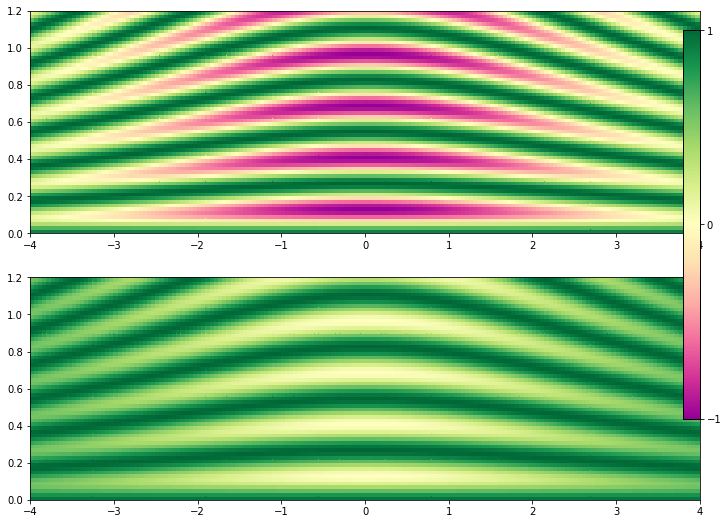

In [10]:
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], results.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], results.results[1],ax=axGrids[1], gif=fig, setC=setC)

In [11]:
JCSys.reset()
JCSys.createSysCoupling([qub,cav],[QuantumToolbox.operators.sigmax, QuantumToolbox.operators.create], couplingStrength=g)
JCSys.createSysCoupling([cav, qub],[QuantumToolbox.operators.destroy, QuantumToolbox.operators.sigmax], couplingStrength=g)
JCSys.couplingName = 'Rabi'

print(JCSys.couplingName)

Rabi


In [12]:
print('simulating')
statesDigit = qSim.run(p)
print(JCSys._QuantumSystem__kept)

simulating
{'JC': [{'qCoupling1': <qTools.classes.QSys.qCoupling object at 0xa166d8cd0>}, <qTools.classes.QPro.freeEvolution object at 0xa166cad70>]}


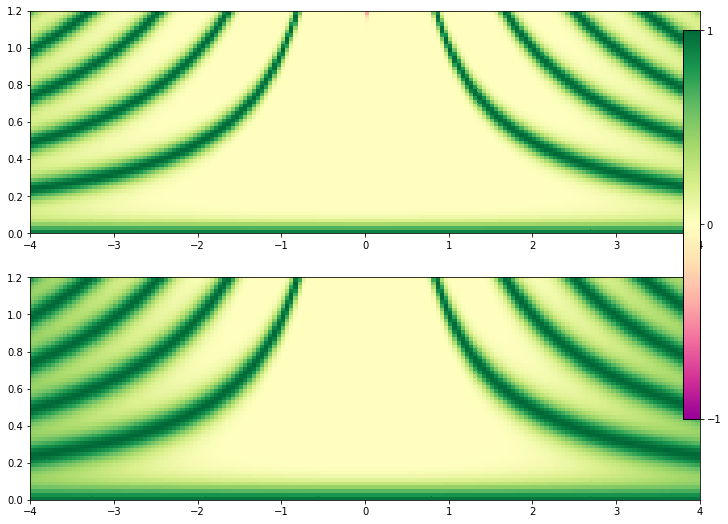

In [13]:
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[1],ax=axGrids[1], gif=fig, setC=setC)

In [14]:
JCSys.reset(to='JC')
#JCSys.addCoupling([qub,cav],[qtbox.operators.destroy, qtbox.operators.create], g)
#JCSys.addCoupling([cav, qub],[qtbox.operators.destroy, qtbox.operators.create], g)
JCSys.unitary = digitalRabi

In [15]:
print('simulating')
cavFreqSweep.sweepList = np.arange(-2, 2+0.025, 0.025)
'''for i in range(len(cavFreqSweep.sweepList)):
    qSim.evolveTimeIndep(cav, cavFreqSweep.sweepList[i])'''
results = qSim.run(p)
print(JCSys._QuantumSystem__kept)

simulating
{'JC': [{'qCoupling1': <qTools.classes.QSys.qCoupling object at 0xa166d8cd0>}, <qTools.classes.QPro.freeEvolution object at 0xa166cad70>], 'Rabi': [{'qCoupling2': <qTools.classes.QSys.qCoupling object at 0xa190888d0>, 'qCoupling3': <qTools.classes.QSys.qCoupling object at 0xa19088a50>}, <qTools.classes.QPro.freeEvolution object at 0xa190c4550>]}


(-4, 4)

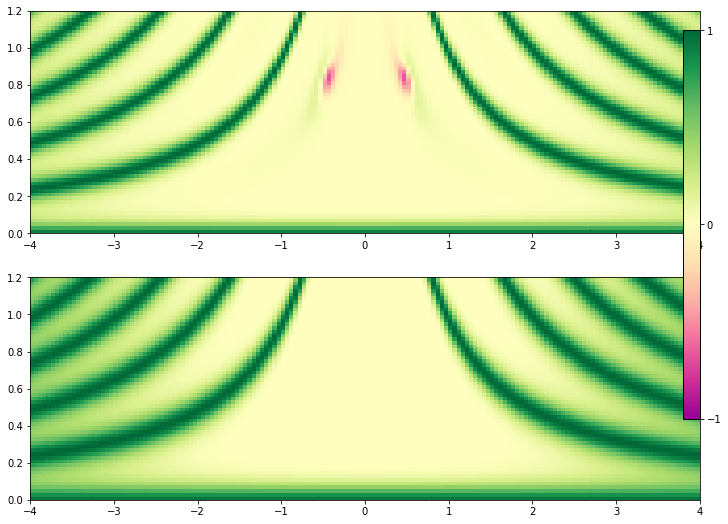

In [16]:
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList*2, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList*2, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[1],ax=axGrids[1], gif=fig, setC=setC)
axGrids[0].set_xlim([-4, 4])
axGrids[1].set_xlim([-4, 4])

In [ ]:
JCSys.reset(to='Rabi')
print('simulating')
asdasd = qSim.run(p)
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[1],ax=axGrids[1], gif=fig, setC=setC)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to='JC')
JCcoupling.couplingStrength = 1
print('simulating')
statesDigit = qSim.run(p)
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[1],ax=axGrids[1], gif=fig, setC=setC)
print(JCSys._QuantumSystem__kept)

In [ ]:
JCSys.reset(to=2)
print(JCSys.couplingName)
JCcoupling.couplingStrength = 1.79
print('simulating')
statesDigit = qSim.run(p)
parityDigit = p.map(partial(expectationKetList, cavParity),statesDigit)
fig = plt.figure(figsize=(12,9))
setC = [0.88, 0.25, 0.02, 0.6]
axGrids = ck.Plotting.Functions.grid(2, 1, fig=fig)

ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[0],ax=axGrids[0], gif=fig, setC=setC)
ck.Plotting.SimplePlots.colorPlot(cavFreqSweep.sweepList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results[1],ax=axGrids[1], gif=fig, setC=setC)
print(JCSys._QuantumSystem__kept)